# Goal Programming: Multi-Objective Optimization

This notebook demonstrates **goal programming** using LumiX for multi-objective optimization with prioritized soft constraints.

## Problem Description

A manufacturing company has multiple conflicting objectives:

1. **Meet production targets** (highest priority)
2. **Limit overtime hours** (medium priority)
3. **Achieve profit target** (lower priority)

Traditional LP can only optimize a single objective. Goal programming converts soft constraints into goals that can be violated with penalty.

## Mathematical Formulation

**Standard Constraint:**
$$\sum_j a_{ij} x_j \leq b_i$$

**Goal Constraint with Deviations:**
$$\sum_j a_{ij} x_j + d_i^- - d_i^+ = b_i$$

where:
- $d_i^-$: Under-achievement (negative deviation)
- $d_i^+$: Over-achievement (positive deviation)
- $d_i^-, d_i^+ \geq 0$

**Objective:** Minimize weighted sum of deviations:
$$\min \sum_i w_i \cdot (d_i^- + d_i^+)$$

## Key Concepts

- **Hard constraints**: Must be satisfied
- **Soft constraints (goals)**: Can be violated with penalty
- **Priorities**: Higher priority goals are more important
- **Weights**: Relative importance within same priority
- **Deviation variables**: Measure goal violation

## 1. Setup and Imports

In [1]:
# Standard library
from dataclasses import dataclass
from typing import List, Dict

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import (
    LXConstraint,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXVariable,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Definition

In [2]:
@dataclass
class Product:
    """Product with production targets."""
    id: int
    name: str
    target_production: float  # Minimum production goal
    hours_per_unit: float
    profit_per_unit: float


# Sample products
PRODUCTS = [
    Product(id=1, name="Product A", target_production=100, hours_per_unit=2.0, profit_per_unit=10.0),
    Product(id=2, name="Product B", target_production=80, hours_per_unit=3.0, profit_per_unit=15.0),
    Product(id=3, name="Product C", target_production=60, hours_per_unit=4.0, profit_per_unit=20.0),
]

# Resource constraints
MAX_HOURS = 500  # Hard capacity limit
TARGET_PROFIT = 3000  # Profit goal
MAX_OVERTIME = 50  # Overtime hour limit goal

In [3]:
# Display data
prod_df = pd.DataFrame([{
    'Product': p.name,
    'Target': p.target_production,
    'Hours/Unit': p.hours_per_unit,
    'Profit/Unit': f'${p.profit_per_unit:.0f}'
} for p in PRODUCTS])

print("Product Data:")
display(prod_df.set_index('Product'))

print(f"\nConstraints:")
print(f"  Max Hours (hard):    {MAX_HOURS} hours")
print(f"  Target Profit:       ${TARGET_PROFIT}")
print(f"  Max Overtime (goal): {MAX_OVERTIME} hours")

# Check feasibility
min_hours_needed = sum(p.target_production * p.hours_per_unit for p in PRODUCTS)
max_profit_possible = sum(p.target_production * p.profit_per_unit for p in PRODUCTS)
print(f"\nMinimum hours to meet all targets: {min_hours_needed} hours")
print(f"Maximum profit at targets: ${max_profit_possible}")

Product Data:


,Target,Hours/Unit,Profit/Unit
Product,,,
Product A,100,2.0,$10
Product B,80,3.0,$15
Product C,60,4.0,$20



Constraints:
  Max Hours (hard):    500 hours
  Target Profit:       $3000
  Max Overtime (goal): 50 hours

Minimum hours to meet all targets: 680.0 hours
Maximum profit at targets: $3400.0


## 3. Goal Programming Concepts

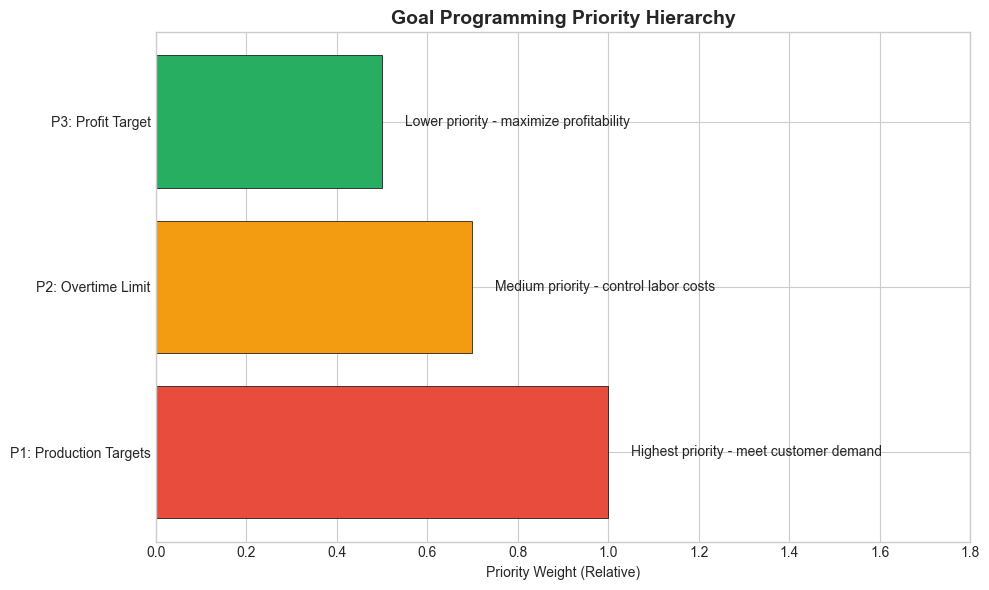


Goal Programming Priority Weights (Exponential):
  Priority 1: weight × 10^6 (highest)
  Priority 2: weight × 10^5
  Priority 3: weight × 10^4 (lowest)

This ensures higher priorities are satisfied first.


In [4]:
# Visualize the goal structure
fig, ax = plt.subplots(figsize=(10, 6))

# Priority hierarchy
priorities = [
    ("P1: Production Targets", 1, "#e74c3c", "Highest priority - meet customer demand"),
    ("P2: Overtime Limit", 2, "#f39c12", "Medium priority - control labor costs"),
    ("P3: Profit Target", 3, "#27ae60", "Lower priority - maximize profitability"),
]

y_pos = np.arange(len(priorities))
heights = [1.0, 0.7, 0.5]  # Visual importance
colors = [p[2] for p in priorities]
labels = [p[0] for p in priorities]

bars = ax.barh(y_pos, heights, color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Priority Weight (Relative)')
ax.set_title('Goal Programming Priority Hierarchy', fontsize=14, fontweight='bold')

# Add descriptions
for i, (name, _, _, desc) in enumerate(priorities):
    ax.text(heights[i] + 0.05, i, desc, va='center', fontsize=10)

ax.set_xlim(0, 1.8)
plt.tight_layout()
plt.show()

print("\nGoal Programming Priority Weights (Exponential):")
print("  Priority 1: weight × 10^6 (highest)")
print("  Priority 2: weight × 10^5")
print("  Priority 3: weight × 10^4 (lowest)")
print("\nThis ensures higher priorities are satisfied first.")

## 4. Build Goal Programming Model

In [5]:
def build_goal_model() -> LXModel:
    """
    Build goal programming model with prioritized soft constraints.
    """
    # Decision variables
    production = (
        LXVariable[Product, float]("production")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda p: p.id)
        .from_data(PRODUCTS)
    )

    # Overtime variable (single instance)
    overtime = (
        LXVariable[int, float]("overtime")
        .continuous()
        .bounds(lower=0)
        .indexed_by(lambda x: x)
        .from_data([1])
    )

    model = LXModel("goal_programming")
    model.add_variables(production, overtime)

    # HARD CONSTRAINT: Total hours <= capacity + overtime
    hours_expr = LXLinearExpression()
    hours_expr.add_term(production, lambda p: p.hours_per_unit)
    hours_expr.add_term(overtime, coeff=-1.0)  # Subtract overtime allowance

    model.add_constraint(
        LXConstraint("capacity").expression(hours_expr).le().rhs(MAX_HOURS)
    )

    # GOAL 1: Meet production targets (Priority 1, highest)
    for product in PRODUCTS:
        prod_expr = LXLinearExpression()
        prod_expr.add_term(
            production,
            coeff=lambda p, prod=product: 1.0 if p.id == prod.id else 0.0
        )

        model.add_constraint(
            LXConstraint(f"production_goal_{product.id}")
            .expression(prod_expr)
            .ge()
            .rhs(product.target_production)
            .as_goal(priority=1, weight=1.0)  # Highest priority
        )

    # GOAL 2: Limit overtime (Priority 2, medium)
    overtime_expr = LXLinearExpression().add_term(overtime, coeff=1.0)

    model.add_constraint(
        LXConstraint("overtime_goal")
        .expression(overtime_expr)
        .le()
        .rhs(MAX_OVERTIME)
        .as_goal(priority=2, weight=1.0)  # Medium priority
    )

    # GOAL 3: Achieve target profit (Priority 3, lowest)
    profit_expr = LXLinearExpression()
    profit_expr.add_term(production, lambda p: p.profit_per_unit)

    model.add_constraint(
        LXConstraint("profit_goal")
        .expression(profit_expr)
        .ge()
        .rhs(TARGET_PROFIT)
        .as_goal(priority=3, weight=1.0)  # Lowest priority
    )

    # Configure goal programming
    model.set_goal_mode("weighted")
    model.prepare_goal_programming()

    return model


model = build_goal_model()
print("Model Summary:")
print(model.summary())

Model Summary:
LXModel: goal_programming
  Variable Families: 12
  Constraint Families: 6
  Objective: min



## 5. Solve the Model

In [6]:
# Solve
optimizer = LXOptimizer().use_solver("ortools")
solution = optimizer.solve(model)

print(f"Solution Status: {solution.status}")
print(f"Objective Value: {solution.objective_value:.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 17:22:07 - lumix.optimizer - INFO - Created model 'goal_programming' with 12 variables and 6 constraints
2025-12-12 17:22:07 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 17:22:07 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 1300000.0000 | Time: 0.00s


Solution Status: optimal
Objective Value: 1300000.00
Solve Time: 0.000s


## 6. Analyze Results

In [7]:
# Extract solution values
# For indexed variables, solution.variables["name"] returns Dict[index, value]
production_values = solution.variables.get("production", {})
if not isinstance(production_values, dict):
    production_values = {}

# Get overtime value (indexed by single element [1])
overtime_values = solution.variables.get("overtime", {})
overtime_value = overtime_values.get(1, 0) if isinstance(overtime_values, dict) else overtime_values

# Calculate metrics
actual_profit = sum(
    production_values.get(p.id, 0) * p.profit_per_unit for p in PRODUCTS
)
total_hours = sum(
    production_values.get(p.id, 0) * p.hours_per_unit for p in PRODUCTS
)

print("Production Plan:")
print("="*60)
results_data = []

for p in PRODUCTS:
    qty = production_values.get(p.id, 0)
    deviation = qty - p.target_production
    status = "MET" if deviation >= -0.01 else "SHORT"
    
    results_data.append({
        'Product': p.name,
        'Target': p.target_production,
        'Actual': qty,
        'Deviation': deviation,
        'Status': status,
        'Profit': qty * p.profit_per_unit
    })
    print(f"{p.name}: {qty:.1f} units (Target: {p.target_production}) [{status}]")

results_df = pd.DataFrame(results_data)
print(f"\nOvertime: {overtime_value:.1f} hours (Limit: {MAX_OVERTIME})")
print(f"Total Hours: {total_hours:.1f} (Capacity: {MAX_HOURS})")
print(f"Actual Profit: ${actual_profit:.2f} (Target: ${TARGET_PROFIT})")

Production Plan:
Product A: 100.0 units (Target: 100) [MET]
Product B: 80.0 units (Target: 80) [MET]
Product C: 60.0 units (Target: 60) [MET]

Overtime: 180.0 hours (Limit: 50)
Total Hours: 680.0 (Capacity: 500)
Actual Profit: $3400.00 (Target: $3000)


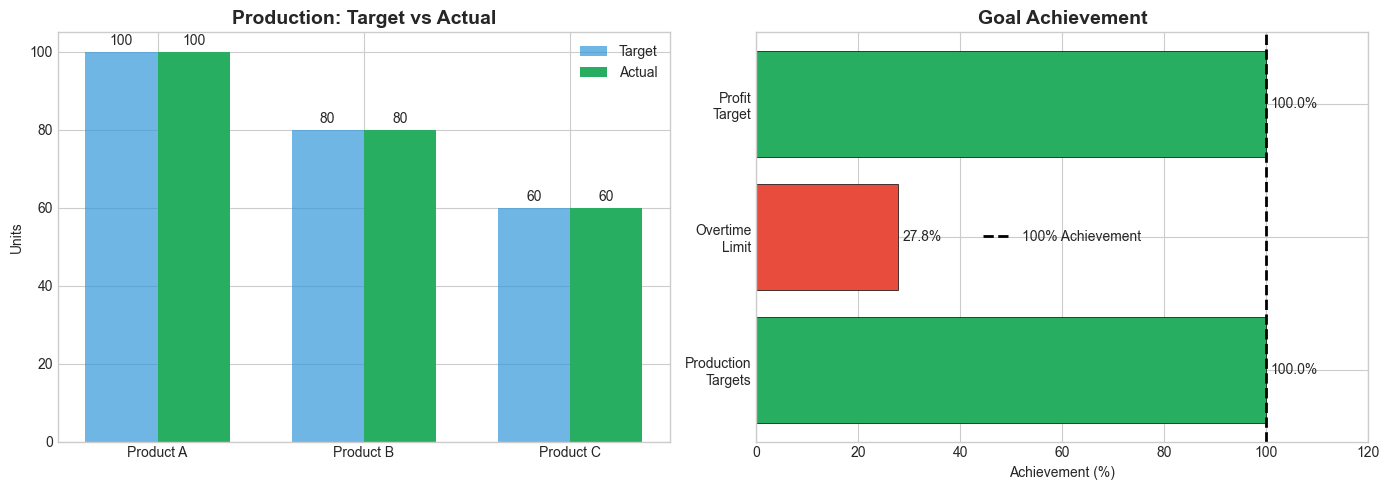

In [8]:
# Visualize production vs targets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

products = [p.name for p in PRODUCTS]
targets = [p.target_production for p in PRODUCTS]
actuals = [production_values.get(p.id, 0) for p in PRODUCTS]

# Production comparison
ax1 = axes[0]
x = np.arange(len(products))
width = 0.35

bars1 = ax1.bar(x - width/2, targets, width, label='Target', color='#3498db', alpha=0.7)
bars2 = ax1.bar(x + width/2, actuals, width, label='Actual', color='#27ae60')

ax1.set_ylabel('Units')
ax1.set_title('Production: Target vs Actual', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(products)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)
ax1.bar_label(bars2, fmt='%.0f', padding=3)

# Goal achievement radar chart
ax2 = axes[1]

# Calculate goal achievement percentages
prod_achievement = min(100, (sum(actuals) / sum(targets)) * 100)
overtime_achievement = min(100, (1 - overtime_value / (MAX_OVERTIME + 50)) * 100) if overtime_value <= MAX_OVERTIME else (MAX_OVERTIME / overtime_value) * 100
profit_achievement = min(100, (actual_profit / TARGET_PROFIT) * 100)

goals = ['Production\nTargets', 'Overtime\nLimit', 'Profit\nTarget']
achievements = [prod_achievement, overtime_achievement, profit_achievement]
colors = ['#27ae60' if a >= 100 else '#f39c12' if a >= 80 else '#e74c3c' for a in achievements]

bars3 = ax2.barh(goals, achievements, color=colors, edgecolor='black', linewidth=0.5)
ax2.axvline(x=100, color='black', linestyle='--', linewidth=2, label='100% Achievement')
ax2.set_xlabel('Achievement (%)')
ax2.set_title('Goal Achievement', fontsize=14, fontweight='bold')
ax2.bar_label(bars3, fmt='%.1f%%', padding=3)
ax2.set_xlim(0, 120)
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Goal Satisfaction Analysis

In [9]:
# Analyze goal satisfaction
print("="*60)
print("GOAL SATISFACTION ANALYSIS")
print("="*60)

goal_results = []

# Priority 1: Production goals
print("\nPriority 1 (Production Targets):")
print("-"*40)

for product in PRODUCTS:
    goal_name = f"production_goal_{product.id}"
    deviations = solution.get_goal_deviations(goal_name)
    
    qty = production_values.get(product.id, 0)
    shortfall = max(0, product.target_production - qty)
    satisfied = shortfall < 0.01
    status = "SATISFIED" if satisfied else "NOT SATISFIED"
    
    goal_results.append({
        'Goal': f"Production {product.name}",
        'Priority': 1,
        'Target': product.target_production,
        'Actual': qty,
        'Deviation': -shortfall,
        'Satisfied': satisfied
    })
    
    symbol = "[OK]" if satisfied else "[!!]"
    print(f"{symbol} {product.name}: Shortfall = {shortfall:.2f} units")

# Priority 2: Overtime goal
print("\nPriority 2 (Overtime Limit):")
print("-"*40)

overtime_excess = max(0, overtime_value - MAX_OVERTIME)
overtime_satisfied = overtime_excess < 0.01
status = "SATISFIED" if overtime_satisfied else "NOT SATISFIED"

goal_results.append({
    'Goal': "Overtime Limit",
    'Priority': 2,
    'Target': MAX_OVERTIME,
    'Actual': overtime_value,
    'Deviation': -overtime_excess,
    'Satisfied': overtime_satisfied
})

symbol = "[OK]" if overtime_satisfied else "[!!]"
print(f"{symbol} Overtime: Excess = {overtime_excess:.2f} hours")

# Priority 3: Profit goal
print("\nPriority 3 (Profit Target):")
print("-"*40)

profit_shortfall = max(0, TARGET_PROFIT - actual_profit)
profit_satisfied = profit_shortfall < 0.01
status = "SATISFIED" if profit_satisfied else "NOT SATISFIED"

goal_results.append({
    'Goal': "Profit Target",
    'Priority': 3,
    'Target': TARGET_PROFIT,
    'Actual': actual_profit,
    'Deviation': -profit_shortfall,
    'Satisfied': profit_satisfied
})

symbol = "[OK]" if profit_satisfied else "[!!]"
print(f"{symbol} Profit: Shortfall = ${profit_shortfall:.2f}")

# Summary table
goal_df = pd.DataFrame(goal_results)
print("\n" + "="*60)
print("Goal Summary:")
display(goal_df.round(2))

GOAL SATISFACTION ANALYSIS

Priority 1 (Production Targets):
----------------------------------------
[OK] Product A: Shortfall = 0.00 units
[OK] Product B: Shortfall = 0.00 units
[OK] Product C: Shortfall = 0.00 units

Priority 2 (Overtime Limit):
----------------------------------------
[!!] Overtime: Excess = 130.00 hours

Priority 3 (Profit Target):
----------------------------------------
[OK] Profit: Shortfall = $0.00

Goal Summary:


,Goal,Priority,Target,Actual,Deviation,Satisfied
0,Production Product A,1,100,100.0,0.0,True
1,Production Product B,1,80,80.0,0.0,True
2,Production Product C,1,60,60.0,0.0,True
3,Overtime Limit,2,50,180.0,-130.0,False
4,Profit Target,3,3000,3400.0,0.0,True


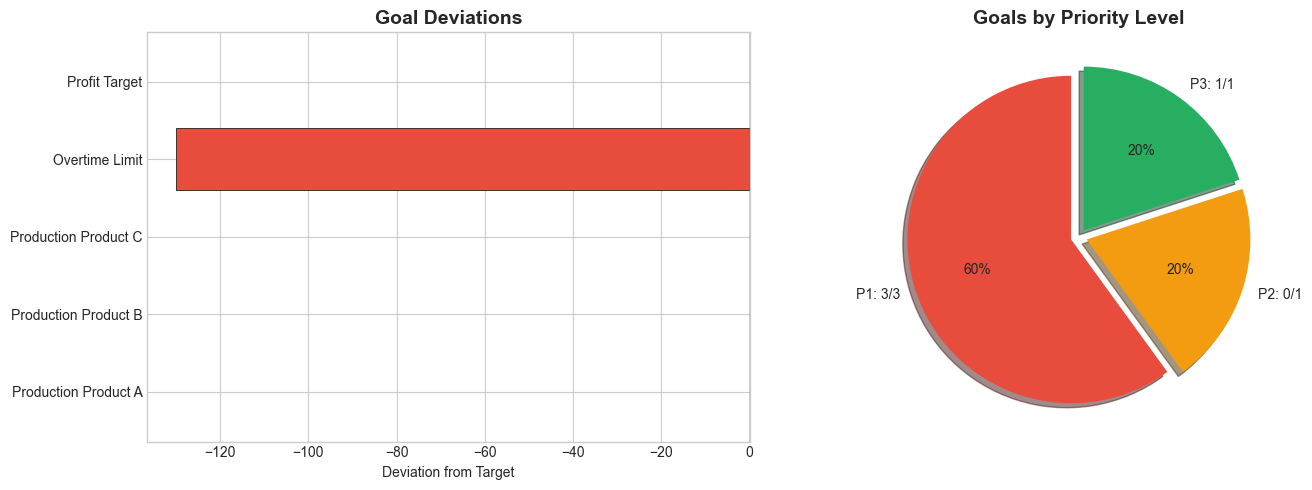

In [10]:
# Goal deviation visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deviation by goal
ax1 = axes[0]
goals = goal_df['Goal'].values
deviations = goal_df['Deviation'].values
satisfied = goal_df['Satisfied'].values

colors = ['#27ae60' if s else '#e74c3c' for s in satisfied]
bars = ax1.barh(goals, deviations, color=colors, edgecolor='black', linewidth=0.5)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Deviation from Target')
ax1.set_title('Goal Deviations', fontsize=14, fontweight='bold')

# Add labels
for i, (goal, dev, sat) in enumerate(zip(goals, deviations, satisfied)):
    status = "OK" if sat else "MISS"
    ax1.text(0.02, i, f" [{status}]", va='center', fontsize=10, fontweight='bold',
             color='white' if sat else 'white')

# Priority breakdown pie chart
ax2 = axes[1]

# Count satisfied by priority
p1_satisfied = sum(1 for r in goal_results if r['Priority'] == 1 and r['Satisfied'])
p1_total = sum(1 for r in goal_results if r['Priority'] == 1)
p2_satisfied = sum(1 for r in goal_results if r['Priority'] == 2 and r['Satisfied'])
p2_total = sum(1 for r in goal_results if r['Priority'] == 2)
p3_satisfied = sum(1 for r in goal_results if r['Priority'] == 3 and r['Satisfied'])
p3_total = sum(1 for r in goal_results if r['Priority'] == 3)

labels = [f'P1: {p1_satisfied}/{p1_total}', f'P2: {p2_satisfied}/{p2_total}', f'P3: {p3_satisfied}/{p3_total}']
sizes = [p1_total, p2_total, p3_total]
colors = ['#e74c3c', '#f39c12', '#27ae60']
explode = [0.05, 0.05, 0.05]

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax2.set_title('Goals by Priority Level', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Resource Utilization

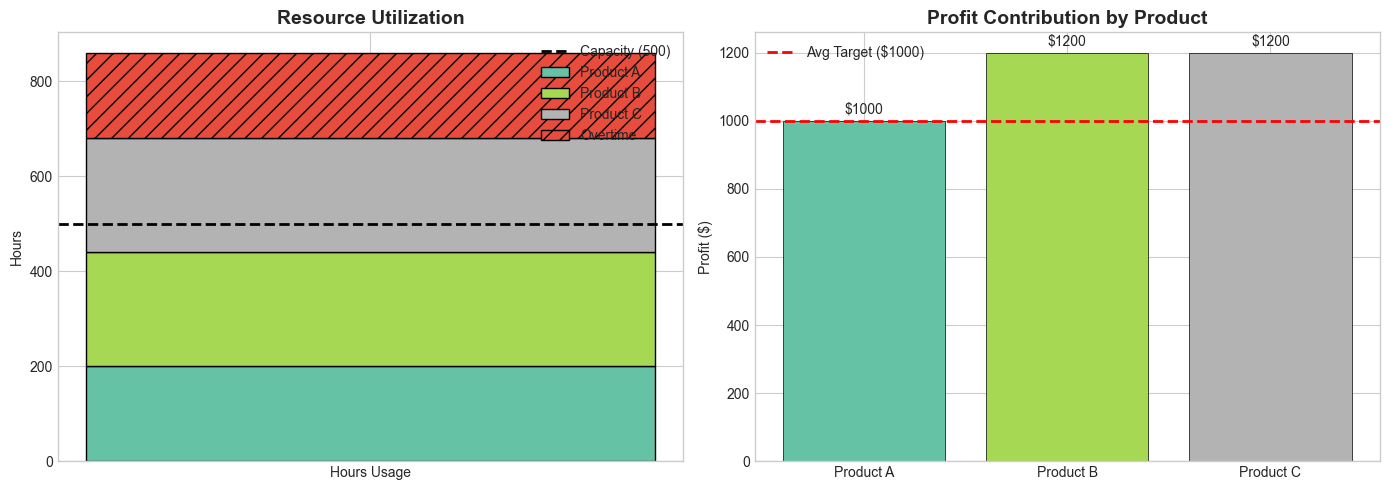


Total Regular Hours: 500.0
Total Overtime: 180.0
Capacity Utilization: 100.0%


In [11]:
# Resource utilization analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hours breakdown by product
ax1 = axes[0]
hours_by_product = [production_values.get(p.id, 0) * p.hours_per_unit for p in PRODUCTS]
product_names = [p.name for p in PRODUCTS]

# Stacked bar for capacity
bottom = 0
colors = plt.cm.Set2(np.linspace(0, 1, len(PRODUCTS)))

for i, (p, hours, color) in enumerate(zip(PRODUCTS, hours_by_product, colors)):
    ax1.bar(['Hours Usage'], [hours], bottom=bottom, label=p.name, color=color, edgecolor='black')
    bottom += hours

# Add overtime
if overtime_value > 0:
    ax1.bar(['Hours Usage'], [overtime_value], bottom=bottom, label='Overtime', 
            color='#e74c3c', edgecolor='black', hatch='//')

ax1.axhline(y=MAX_HOURS, color='black', linestyle='--', linewidth=2, label=f'Capacity ({MAX_HOURS})')
ax1.set_ylabel('Hours')
ax1.set_title('Resource Utilization', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')

# Profit breakdown
ax2 = axes[1]
profit_by_product = [production_values.get(p.id, 0) * p.profit_per_unit for p in PRODUCTS]

bars = ax2.bar(product_names, profit_by_product, color=colors, edgecolor='black', linewidth=0.5)
ax2.axhline(y=TARGET_PROFIT / len(PRODUCTS), color='red', linestyle='--', 
            linewidth=2, label=f'Avg Target (${TARGET_PROFIT/len(PRODUCTS):.0f})')
ax2.set_ylabel('Profit ($)')
ax2.set_title('Profit Contribution by Product', fontsize=14, fontweight='bold')
ax2.bar_label(bars, fmt='$%.0f', padding=3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nTotal Regular Hours: {total_hours - overtime_value:.1f}")
print(f"Total Overtime: {overtime_value:.1f}")
print(f"Capacity Utilization: {(total_hours - overtime_value) / MAX_HOURS * 100:.1f}%")

## 9. Key Insights

In [12]:
# Summary insights
print("="*60)
print("GOAL PROGRAMMING SUMMARY")
print("="*60)

satisfied_count = sum(1 for r in goal_results if r['Satisfied'])
total_count = len(goal_results)

print(f"\nGoals Satisfied: {satisfied_count}/{total_count} ({satisfied_count/total_count*100:.0f}%)")

print("\nBy Priority Level:")
for priority in [1, 2, 3]:
    p_satisfied = sum(1 for r in goal_results if r['Priority'] == priority and r['Satisfied'])
    p_total = sum(1 for r in goal_results if r['Priority'] == priority)
    print(f"  Priority {priority}: {p_satisfied}/{p_total} goals satisfied")

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("""
1. PRIORITY HIERARCHY:
   - Higher priority goals are satisfied before lower priority
   - Priority 1 (production) takes precedence over profit targets
   - This reflects business reality: customer commitments first

2. TRADE-OFFS:
   - Meeting all production targets may require overtime
   - Overtime increases costs, reducing profit
   - Goal programming quantifies these trade-offs

3. FLEXIBILITY:
   - Soft constraints allow infeasible problems to find solutions
   - Deviation variables show where goals are missed
   - Weights can be adjusted to change goal importance

4. BUSINESS APPLICATION:
   - Strategic planning with multiple objectives
   - Resource allocation under constraints
   - Balancing conflicting stakeholder requirements
""")

GOAL PROGRAMMING SUMMARY

Goals Satisfied: 4/5 (80%)

By Priority Level:
  Priority 1: 3/3 goals satisfied
  Priority 2: 0/1 goals satisfied
  Priority 3: 1/1 goals satisfied

KEY INSIGHTS

1. PRIORITY HIERARCHY:
   - Higher priority goals are satisfied before lower priority
   - Priority 1 (production) takes precedence over profit targets
   - This reflects business reality: customer commitments first

2. TRADE-OFFS:
   - Meeting all production targets may require overtime
   - Overtime increases costs, reducing profit
   - Goal programming quantifies these trade-offs

3. FLEXIBILITY:
   - Soft constraints allow infeasible problems to find solutions
   - Deviation variables show where goals are missed
   - Weights can be adjusted to change goal importance

4. BUSINESS APPLICATION:
   - Strategic planning with multiple objectives
   - Resource allocation under constraints
   - Balancing conflicting stakeholder requirements



## 10. Goal Programming Methods

### Weighted Goal Programming (Used Above)
- Single optimization with weighted deviations
- Priorities converted to exponential weights
- Fast: one solve operation

### Lexicographic Goal Programming
- Sequential optimization by priority
- First optimize P1, then P2 (fixing P1), etc.
- Guarantees strict priority ordering

### LumiX API Summary

```python
# Mark constraint as goal
constraint.as_goal(priority=1, weight=1.0)

# Set goal mode
model.set_goal_mode("weighted")  # or "lexicographic"

# Prepare goal programming (creates deviation vars)
model.prepare_goal_programming()

# After solving
solution.get_goal_deviations("goal_name")
solution.is_goal_satisfied("goal_name")
```

## 11. Extensions & Exercises

1. **Lexicographic mode**: Change to sequential priority optimization
2. **Custom weights**: Weight production goals by customer revenue
3. **More goals**: Add quality targets, employee satisfaction
4. **Sensitivity**: Analyze how changing priorities affects solution
5. **Multi-period**: Extend to rolling planning horizon